In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import numpy as np
import jax
from jax import jit
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from jwave import FiniteDifferences, FourierSeries
from jwave.geometry import Domain, Medium, circ_mask
from jwave.utils import display_complex_field, show_positive_field

import sys
sys.path.append('../')

key = random.PRNGKey(42)  # Random seed

2024-08-18 01:51:48.112700: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.20). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [72]:
# define linear ultrasound transducer (P4-1)
nelements = 96
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 2.5e6 # frequency of the transducer [Hz]
omega = 2 * np.pi * transducer_frequency # angular
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.028 m


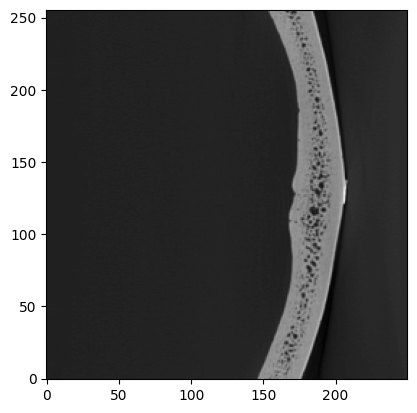

In [73]:
import pydicom

# define skull slice
skull_dicom = pydicom.dcmread("../data/skull_slice.dcm")
skull_array = skull_dicom.pixel_array.astype(np.int16)
skull_array = skull_array[:500, 600:-600]
skull_array = np.flipud(skull_array)
downsampling_factor = 2
new_shape = (skull_array.shape[0] // downsampling_factor, skull_array.shape[1] // downsampling_factor)
skull_array = jax.image.resize(skull_array, new_shape, method='nearest').T
plt.imshow(skull_array, cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [74]:
from jwave_utils import get_domain

# define spatial parameters
N = np.array(skull_array.shape).astype(int) # grid size [grid points]
dx = np.array([9.07935931401377e-5*downsampling_factor, 9.07935931401377e-5*downsampling_factor]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

domain = get_domain(N, dx)

In [75]:
# define real transducer positions
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)
element_positions

array([[ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175],
       [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230,

In [76]:
             # frequency [Hz] | attenuation [Np/m]
skull_attenuations = {0.5e6   : 27.2765, 
                        1e6   : 54.553,
                        2.5e6 : 136.3825,
                        4e6   : 272.765
                      }
water_attenuations = {0.5e6   : 0.0126642180115,
                        1e6   : 0.025328436023,
                        2.5e6 : 0.0633210900575,
                        4e6   : 0.101313744092
                        }

In [83]:
from jwave_utils import get_homogeneous_medium, get_skull_medium

# get mediums
c0 = 1500 # speed of sound in water [m/s]
speed_homogeneous, density_homogeneous = get_homogeneous_medium(domain, background_std=0)
attenuation_homogeneous = water_attenuations[transducer_frequency]

speed_homogeneous = FourierSeries(jnp.expand_dims(speed_homogeneous, -1), domain)
density_homogeneous = FourierSeries(jnp.expand_dims(density_homogeneous, -1), domain)
attenuation_homogeneous = FourierSeries(jnp.expand_dims(attenuation_homogeneous, -1), domain)

speed_skull, density_skull = get_skull_medium(domain, skull_array, background_std=0)
attenuation_skull = np.zeros(domain.N)
attenuation_skull[skull_array > 20000] = skull_attenuations[transducer_frequency]
attenuation_skull[attenuation_skull==0] = water_attenuations[transducer_frequency]

speed_skull = FourierSeries(jnp.expand_dims(speed_skull, -1), domain)
density_skull = FourierSeries(jnp.expand_dims(density_skull, -1), domain)
attenuation_skull = FourierSeries(jnp.expand_dims(attenuation_skull, -1), domain)

medium = Medium(
    domain=domain,
    sound_speed=speed_skull,
    density=density_skull,
    attenuation=0,#attenuation_skull,
    pml_size=pml[0],
)

medium_homogenous = Medium(
    domain=domain,
    sound_speed=speed_homogeneous,
    density=density_homogeneous,
    attenuation=0,#attenuation_homogeneous,
    pml_size=pml[0],
)

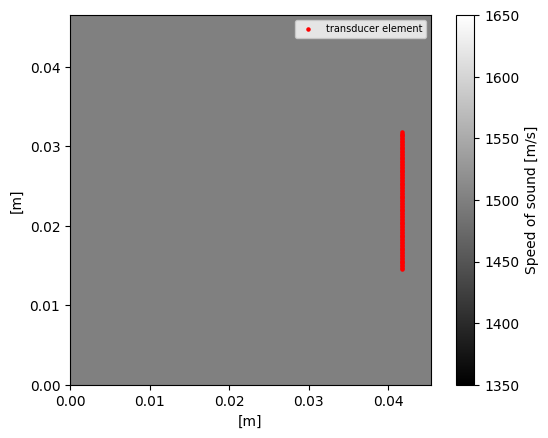

In [84]:
ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(medium_homogenous.sound_speed.params, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

In [85]:
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[element_positions[0], element_positions[1]].set(1.0)
src = FourierSeries(jnp.expand_dims(src_field, -1), domain) * omega

In [86]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

@jit
def solve_helmholtz(medium):
    return helmholtz_solver(medium, omega, src)

field = solve_helmholtz(medium)
field_homogenous = solve_helmholtz(medium_homogenous)

2024-08-18 02:38:16 - jaxdf [WARNING]: Deprecation: Currently only the first output of an operator is considered. This will change in a future release. If you need to return multiple outputs, please return a tuple and a None value, for example: ((out1, out2), None). This happened for the operator `shift_operator`.


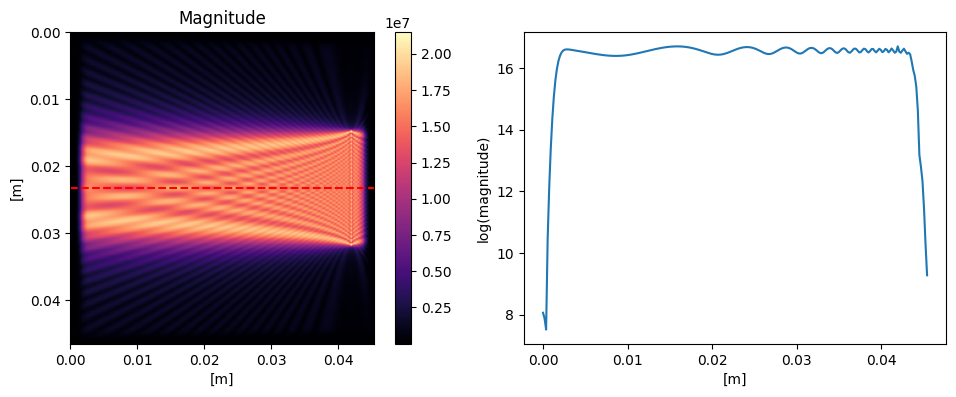

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im = axs[0].imshow(np.abs(field_homogenous.params), cmap='magma', extent=ext)
axs[0].set_title('Magnitude')
axs[0].set_xlabel('[m]')
axs[0].set_ylabel('[m]')
fig.colorbar(im, ax=axs[0])
axs[0].axhline(y=N[0]//2*dx[0], color='r', linestyle='--')

x = np.linspace(0, N[1]*dx[1], N[1])
axs[1].plot(x, np.log(np.abs(field_homogenous.params[N[0]//2, :])))
axs[1].set_xlabel('[m]')
axs[1].set_ylabel('log(magnitude)')

plt.tight_layout()
plt.show()

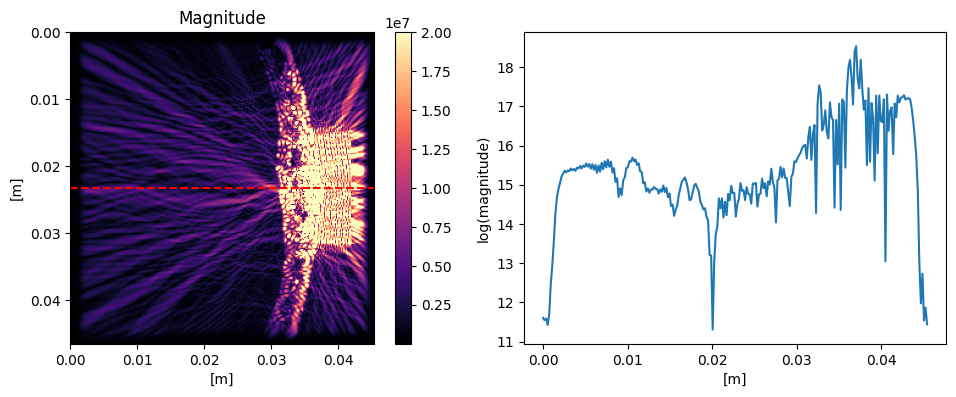

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im = axs[0].imshow(np.abs(field.params), cmap='magma', extent=ext, vmax=2e7)
axs[0].set_title('Magnitude')
axs[0].set_xlabel('[m]')
axs[0].set_ylabel('[m]')
fig.colorbar(im, ax=axs[0])
axs[0].axhline(y=N[0]//2*dx[0], color='r', linestyle='--')

x = np.linspace(0, N[1]*dx[1], N[1])
axs[1].plot(x, np.log(np.abs(field.params[N[0]//2, :])))
axs[1].set_xlabel('[m]')
axs[1].set_ylabel('log(magnitude)')

plt.tight_layout()
plt.show()